<a href="https://colab.research.google.com/github/Madhumeth/project-1/blob/main/Fingerprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

import os
import datetime


print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU: ", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
GPU:  NOT AVAILABLE


In [2]:
img_data = np.load('img_train.npy')
label_data = np.load('label_train.npy')
img_real = np.load('img_real.npy')
label_real = np.load('label_real.npy')

In [3]:
def hist_stretch(img_buf, width, height, shift):
    tmp1 = 0
    tmp2 = 0
    w_pHistBuf = np.zeros(256, dtype=np.uint32)
    total = 0
    ret_buf = np.zeros((width, height, 1), dtype=np.uint8)

    # get brightness
    for i in range(height):
        for j in range(width):
            total = total + img_buf[i][j][0]
            w_pHistBuf[img_buf[i][j][0]] += 1
    diff = (int)(shift - (total / (width * height)))
    w_pHistBuf = np.zeros(256, dtype=np.uint32)

    # move histogram
    for i in range(height):
        for j in range(width):
            tmp = img_buf[i][j][0] + diff
            if (tmp > 255):
                tmp = 255
            elif (tmp < 0):
                tmp = 0
            ret_buf[i][j][0] = tmp
            w_pHistBuf[tmp] += 1

    # stretch histogram
    for i in range(256):
        if (w_pHistBuf[i] != 0):
            tmp1 = i
            break
    for i in range(255, 0, -1):
        if (w_pHistBuf[i] != 0):
            tmp2 = i
            break
    for i in range(height):
        for j in range(width):
            ret_buf[i][j][0] = (int)((255 * (ret_buf[i][j][0] - tmp1) / (tmp2 - tmp1)))

    return ret_buf

for i in range(img_data.shape[0]):
    img_tmp = hist_stretch(img_data[i], 160, 160, 128)
    img_data[i] = img_tmp

for i in range(img_real.shape[0]):
    img_tmp = hist_stretch(img_real[i], 160, 160, 128)
    img_real[i] = img_tmp

In [4]:
img_train, img_val, label_train, label_val = train_test_split(img_data, label_data, test_size = 0.1)
print(img_data.shape, label_data.shape)
print(img_train.shape, label_train.shape)
print(img_val.shape, label_val.shape)

(800, 160, 160, 1) (800, 1)
(720, 160, 160, 1) (720, 1)
(80, 160, 160, 1) (80, 1)


In [5]:
def build_model():
    x1 = layers.Input(shape = (160, 160, 1))
    x2 = layers.Input(shape = (160, 160, 1))

    # share weights both inputs
    inputs = layers.Input(shape = (160, 160, 1))
    feature = layers.Conv2D(32, kernel_size = 3, activation = 'relu')(inputs)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(64, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(feature)
    feature = layers.MaxPooling2D(pool_size = 2)(feature)
    feature_model = Model(inputs = inputs, outputs = feature)

    # show feature model summary
    feature_model.summary()

    # two feature models that sharing weights
    x1_net = feature_model(x1)
    x2_net = feature_model(x2)

    # subtract features
    net = layers.Subtract()([x1_net, x2_net])
    net = layers.Conv2D(128, kernel_size = 3, activation = 'relu')(net)
    net = layers.MaxPooling2D(pool_size = 2)(net)
    net = layers.Flatten()(net)
    net = layers.Dropout(0.3)(net)
    net = layers.Dense(512, activation = 'relu')(net)
    net = layers.Dense(1, activation = 'sigmoid')(net)
    model = Model(inputs = [x1, x2], outputs = net)

    # compile
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics = ['acc'])

    # show summary
    model.summary()

    return (model, feature_model)

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, img_data, label_data, img_real, label_real, batch_size = 32, shuffle = True):
        'Initialization'
        self.img_data = img_data
        self.label_data = label_data
        self.img_real = img_real
        self.label_real = label_real
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_data) / self.batch_size) * 2)

    def __getitem__(self, index):
        'Generate one batch of data'
        real_idx = index
        index = int(np.floor(index / 2))
        img1_batch = self.img_data[index * self.batch_size : (index + 1) * self.batch_size]
        label1_batch = self.label_data[index * self.batch_size : (index + 1) * self.batch_size]
        img2_batch = np.empty((self.batch_size, 160, 160, 1), dtype = np.float32)
        label2_batch = np.zeros((self.batch_size, 1), dtype = np.float32)

        for i, idx in enumerate(label1_batch):
            if random.random() > 0.5:
                # put matched image
                img2_batch[i] = self.img_real[idx]
                label2_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_idx = random.choice(list(self.label_real))
                    if (unmatch_idx != idx):
                        break

                img2_batch[i] = self.img_real[unmatch_idx]
                label2_batch[i] = 0.

        index = real_idx
        if (index < int(np.floor(len(self.img_data) / self.batch_size))):
            return [img1_batch.astype(np.float32) / 255., img2_batch.astype(np.float32) / 255.], label2_batch

        return [img2_batch.astype(np.float32) / 255., img1_batch.astype(np.float32) / 255.], label2_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.img_data, self.label_data = shuffle(self.img_data, self.label_data)

In [7]:
train_gen = DataGenerator(img_train, label_train, img_real, label_real, shuffle = True)
val_gen = DataGenerator(img_val, label_val, img_real, label_real, shuffle = True)

In [8]:
checkpoint_path = '/kaggle/working/model/checkpoint/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, verbose = 1)

In [9]:
tfb_log_dir = '/kaggle/working/logs/train/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = tfb_log_dir, histogram_freq = 1)

In [10]:
(model, feature_model) = build_model()
if (os.path.exists(checkpoint_path + '.index')):
    print('continue training')
    model.load_weights(checkpoint_path)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 160, 160, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 18, 18, 128)          92672     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 subtract (Subtract)         (None, 18, 18, 128)          0         ['model[0][0]',         

In [ ]:
history = model.fit(train_gen, epochs = 200, validation_data = val_gen, callbacks = [cp_callback, tensorboard_callback])
#history = model.fit(train_gen, epochs = 200, validation_data = val_gen)

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

In [ ]:
history = model.fit(train_gen, epochs = 10, validation_data = val_gen, callbacks = [cp_callback, tensorboard_callback])

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 0.4307 - acc: 0.7969
Epoch 1: saving model to /kaggle/working/model/checkpoint/cp.ckpt
44/44 [==============================] - 143s 3s/step - loss: 0.4307 - acc: 0.7969 - val_loss: 0.6138 - val_acc: 0.7578
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.4349 - acc: 0.8018
Epoch 2: saving model to /kaggle/working/model/checkpoint/cp.ckpt
44/44 [==============================] - 143s 3s/step - loss: 0.4349 - acc: 0.8018 - val_loss: 0.4478 - val_acc: 0.7734
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.4281 - acc: 0.8026
Epoch 3: saving model to /kaggle/working/model/checkpoint/cp.ckpt
44/44 [==============================] - 143s 3s/step - loss: 0.4281 - acc: 0.8026 - val_loss: 0.5011 - val_acc: 0.7734
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 0.4045 - acc: 0.8089
Epoch 4: saving model to /kaggle/working/model/checkpoint/cp.ckpt
44/44 [=============

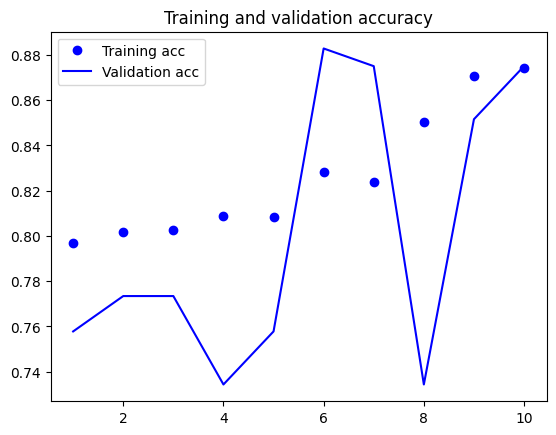

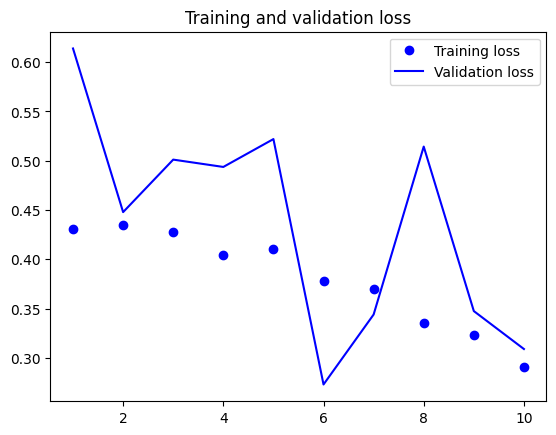

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
model_path = '/kaggle/working/model/fp160.h5'
model_feature_path = '/kaggle/working/model/fp160_feature.h5'
model.save(model_path)
feature_model.save(model_feature_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 179ms/step


<ipython-input-18-633a49ef2001>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('X: %.02f, %s' % (pred_right, db_idx))


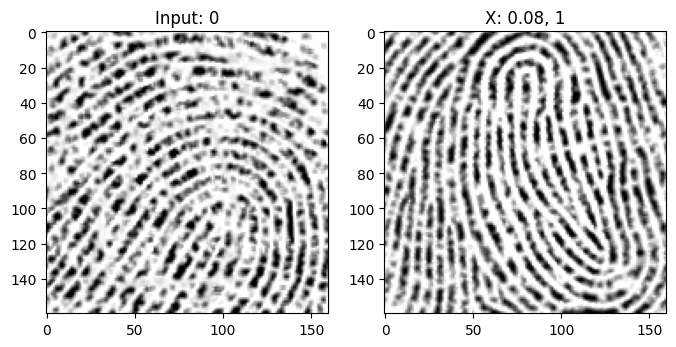

In [18]:
input_idx = 0
db_idx = 1
input_img = img_real[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
db_img = img_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
pred_right = model.predict([input_img, db_img])

# show result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Input: %s' %input_idx)
plt.imshow(input_img.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
if (pred_right > 0.5):
    plt.title('O: %.02f, %s' % (pred_right, db_idx))
else:
    plt.title('X: %.02f, %s' % (pred_right, db_idx))
plt.imshow(db_img.squeeze(), cmap='gray')

In [19]:
total_count = 0
error_count = 0
error_rage = 0.5
for input_idx in range(label_real.shape[0]):
    print('Processing #', input_idx, '')
    for db_idx in range(label_real.shape[0]):
        input_img = img_real[input_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
        db_img = img_real[db_idx].reshape((1, 160, 160, 1)).astype(np.float32) / 255.
        pred_right = model.predict([input_img, db_img])
        if (input_idx == db_idx):
            if (pred_right < error_rage):
                print('False Reject = ', pred_right)
                error_count += 1
        if (input_idx != db_idx):
            if (pred_right > error_rage):
                print('False Accept = ', pred_right, ', ID = ', db_idx)
                error_count += 1
        total_count += 1

# show result
print('Evaluation Finished')
print('Total Count = ', total_count)
print('Error Count = ', error_count)
print('Error Rate = ', (error_count / total_count) * 100)

Processing # 0 
1/1 [==============================] - 0s 76ms/step
Processing # 1 
1/1 [==============================] - 0s 46ms/step
False Accept =  [[0.5106139]] , ID =  7
1/1 [==============================] - 0s 44ms/step
Processing # 2 
1/1 [==============================] - 0s 44ms/step
Processing # 3 
1/1 [==============================] - 0s 45ms/step
False Accept =  [[0.7682503]] , ID =  2
1/1 [==============================] - 0s 48ms/step
Processing # 4 
1/1 [==============================] - 0s 44ms/step
False Accept =  [[0.8619077]] , ID =  6
1/1 [==============================] - 0s 58ms/step
Processing # 5 
1/1 [==============================] - 0s 44ms/step
Processing # 6 
1/1 [==============================] - 0s 118ms/step
False Accept =  [[0.88372904]] , ID =  4
1/1 [==============================] - 0s 121ms/step
Processing # 7 
1/1 [==============================] - 0s 111ms/step
False Accept =  [[0.6139184]] , ID =  1
1/1 [==============================] - 0s 97